# Need to run automatic lfilter as pbs job

In [2]:
import sys
sys.path.append("/home/149/ab8992/tasman-tides/")
import xarray as xr
import ttidelib as tt
import scipy
import cmocean
import os
cmap = cmocean.cm.dense_r
import matplotlib
import matplotlib.pyplot as plt
earth_cmap = matplotlib.cm.get_cmap("gist_earth")
from datetime import timedelta
import filtering
import numpy as np
import dask
from dask.distributed import Client,default_client



def startdask():
    try:
    # Try to get the existing Dask client
        client = default_client()
        print(client)
    except ValueError:
        # If there's no existing client, create a new one
        client = Client()
        print(client)
    return client

client = startdask()


/jobfs/110357939.gadi-pbs/ipykernel_2184337/1970905510.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  earth_cmap = matplotlib.cm.get_cmap("gist_earth")
sh: None: command not found
INFO: Compiled ParcelsRandom ==> /jobfs/110357939.gadi-pbs/parcels-16078/libparcels_random_9eb06c5e-80eb-4dd1-b58d-a71e8f11980f.so
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43845 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:41545' processes=7 threads=28, memory=112.00 GiB>


## Steps:

1. Recipes function calls this script, passing: `zlevels`, `expt`, `t0`, `time_window`,`filter_window`,`filter_cutoff`
2. Make a folder if not exists in the postprocessing folder. Name it after t0. Might also need to make a csv file to keep track of which t0's are eddy vs no eddy? Then label the outputs accordingly
3. Spawn a new pbs job for each z level on 28bw cores as normal. Each script generates a `filtered_0x.nc` file. 
4. Postprocess within each pbs job. Read back in the `filtered_0x.nc` file and restore the attributes *including* the z level.

Could design the function to be recursive, and only do steps 1&2 if qsub = False? 

## Assume we've been passed the following arguments:

In [3]:
t0 = 44900 # Time in the middle of the window to be filtered
# t0 = 38000
time_window = 200 # How many hours either side of t0 to consider
filter_window = 5 # How many hours either side of t0 to actually filter (subset of time window)
zl = 5
expt = "full-20"
filter_cutoff = 2*np.pi/(12.42*3600)
outpath = f"/g/data/nm03/ab8992/postprocessed/{expt}/waves"

#TODO Draft function to go into ttidelib later
def cross_scale_transfer(data):

    tau_uu = data.uu - data.u**2
    tau_uv = data.uv - data.u*data.v
    tau_vv = data.vv - data.v**2
    u = data.u
    v = data.v
    uu = data.uu
    vv = data.vv

    transfer = (
        tau_uu * u.differentiate("xb") +
        tau_uv * u.differentiate("yb") +
        tau_uv * v.differentiate("xb") +
        tau_vv * v.differentiate("yb")
    ).rename("energy_transfer")

    return transfer


## First read in a single that overlaps the eddy

In [ ]:

tmpstorage = os.getenv('PBS_JOBFS')

## COMMENT OUT WHEN DOING NOTIDE SINCE COllECT DATA DOESN'T WORK ON IT
rawdata = tt.collect_data(
    expt,
    rawdata = ["u","v"],
    timerange=(t0 - time_window,t0 + time_window)).isel(zl = [zl])

# Save attributes to re-add later
attrs = {
    "u": rawdata.u.attrs,
    "v": rawdata.v.attrs,
    "time": rawdata.time.attrs,
    "xb": rawdata.xb.attrs,
    "yb": rawdata.yb.attrs,
    "zl": rawdata.zl.attrs,
    "base" : rawdata.attrs
}

## Save z level to re-add later
zl_value = rawdata.zl.values[0]

## Remove zl to make data properly 2D
rawdata = rawdata.isel(zl = 0)

# Strip attrs since lagrange filter complains about them
rawdata.u.attrs = {}
rawdata.v.attrs = {}
rawdata.zl.attrs = {}
rawdata.time.attrs = {}
rawdata.yb.attrs = {}
rawdata.xb.attrs = {}
rawdata = rawdata.assign_coords({
    "time":rawdata.time * 3600,
    "xb":rawdata.xb * 1000,
    "yb":rawdata.yb * 1000})
# rawdata = rawdata.drop(["bathy","lat","lon"]) ## COMMENTED OUT FOR NOTIDE

print("Saving data to temporary storage")

rawdata.u.to_netcdf(tmpstorage + f"/u.nc",mode="w")
rawdata.v.to_netcdf(tmpstorage + f"/v.nc",mode="w")
(rawdata.v**2).rename("vv").to_netcdf(tmpstorage + f"/vv.nc",mode="w")
(rawdata.u**2).rename("uu").to_netcdf(tmpstorage + f"/uu.nc",mode="w")
(rawdata.u*rawdata.v).rename("uv").to_netcdf(tmpstorage + f"/uv.nc",mode="w")
print("done")
client.close()

if os.path.exists(outpath + ".nc"):
    os.remove(outpath + ".nc")
f = filtering.LagrangeFilter(
	tmpstorage + "/filtered", ## Save intermediate output to temporary storage
    {
        "U":tmpstorage + "/u.nc",
        "V":tmpstorage + "/v.nc",
        "uu":tmpstorage + "/uu.nc",
        "vv":tmpstorage + "/vv.nc",
        "uv":tmpstorage + "/uv.nc"
    }, 
    {"U":"u","V":"v","uu":"uu","vv":"vv","uv":"uv"}, 
    {"lon":"xb","lat":"yb","time":"time"},
	sample_variables=["U","V","vv","uu","uv"], mesh="flat",highpass_frequency = filter_cutoff,
    advection_dt =timedelta(hours=2).total_seconds(),
    window_size = timedelta(hours=24).total_seconds(),
)
f(times = range(3600 * (time_window - filter_window),3600 * (time_window + filter_window),3600)) ## Ensure we take times either side of the point of interest

## Remove stored data to save space on disk
for i in ["u","v","uu","vv","uv"]:
    os.remove(tmpstorage + f"/{i}.nc")

client = startdask()

## Load the filtered data
filtered = xr.open_dataset(tmpstorage + "/filtered.nc",chunks = "auto")

## Re-add zl as a dimension. Expand dims, then add zl
filtered = filtered.expand_dims({"zl":[zl_value]})

## Restore scale and attributes of rawdata
filtered = filtered.assign_coords({
    "time":filtered.time / 3600,
    "xb":filtered.xb / 1000,
    "yb":filtered.yb / 1000})

## Fix up names of filtered variables:
for i in filtered.data_vars:
    filtered = filtered.rename({i:i.split("_")[1].lower()})

filtered.attrs = attrs["base"]
filtered.u.attrs = attrs["u"]
filtered.v.attrs = attrs["v"]
filtered.zl.attrs = attrs["zl"]
filtered.time.attrs = attrs["time"]
filtered.yb.attrs = attrs["yb"]
filtered.xb.attrs = attrs["xb"]

filtered.attrs["long_name"] = "Filtered velocity data"

cst = cross_scale_transfer(filtered)

filtered["cst"] = cst

filtered[["u","v","cst"]].to_netcdf(outpath + ".nc",mode="w")



: 

## 2D Version

In [3]:
if os.path.exists(outpath + ".nc"):
    os.remove(outpath + ".nc")
f = filtering.LagrangeFilter(
	outpath,
    {
        "U":tmpstorage + "/u_*.nc",
        "V":tmpstorage + "/v_*.nc",
        "uu":tmpstorage + "/uu_*.nc",
        "vv":tmpstorage + "/vv_*.nc",
        "uv":tmpstorage + "/uv_*.nc"
    }, 
    {"U":"u","V":"v","uu":"uu","vv":"vv","uv":"uv"}, 
    {"lon":"xb","lat":"yb","time":"time"},
	sample_variables=["U","V","vv","uu","uv"], mesh="flat",highpass_frequency = filter_cutoff,
    advection_dt =timedelta(hours=2).total_seconds(),
    window_size = timedelta(hours=24).total_seconds(),
)
f(times = range(3600 * (time_window - filter_window),3600 * (time_window + filter_window),3600)) ## Ensure we take times either side of the point of interest

0.3.0


sh: None: command not found
INFO: Compiled SamplingParticlesample_kernel ==> /jobfs/110262781.gadi-pbs/parcels-16078/f7641448a30a7239759292a322e11e6a_0.so
INFO:parcels.tools.loggers:Compiled SamplingParticlesample_kernel ==> /jobfs/110262781.gadi-pbs/parcels-16078/f7641448a30a7239759292a322e11e6a_0.so
sh: None: command not found
INFO: Compiled SamplingParticleAdvectionRK4sample_kernel ==> /jobfs/110262781.gadi-pbs/parcels-16078/5f74337f9f4a342ad1aed774d9c23cf9_0.so
INFO:parcels.tools.loggers:Compiled SamplingParticleAdvectionRK4sample_kernel ==> /jobfs/110262781.gadi-pbs/parcels-16078/5f74337f9f4a342ad1aed774d9c23cf9_0.so


In [4]:

# NO DEPTH CHUNKING SEE WHAT HAPPENS
tmpstorage = os.getenv('PBS_JOBFS')

## COMMENT OUT WHEN DOING NOTIDE SINCE COllECT DATA DOESN'T WORK ON IT
# rawdata = tt.collect_data(
#     expt,
#     rawdata = ["u","v"],
#     timerange=(t0 - time_window,t0 + time_window)).isel(zl = zl)
rawdata.u.attrs = {}
rawdata.v.attrs = {}
rawdata.zl.attrs = {}
rawdata.time.attrs = {}
rawdata.yb.attrs = {}
rawdata.xb.attrs = {}



rawdata = rawdata.assign_coords({
    "time":rawdata.time * 3600,
    "xb":rawdata.xb * 1000,
    "yb":rawdata.yb * 1000})
# rawdata = rawdata.drop(["bathy","lat","lon"]) ## COMMENTED OUT FOR NOTIDE

print("Saving data to temporary storage")

rawdata.u.to_netcdf(tmpstorage + f"/u_0.nc",mode="w")
rawdata.v.to_netcdf(tmpstorage + f"/v_0.nc",mode="w")
(rawdata.v**2).rename("vv").to_netcdf(tmpstorage + f"/vv_0.nc",mode="w")
(rawdata.u**2).rename("uu").to_netcdf(tmpstorage + f"/uu_0.nc",mode="w")
(rawdata.u*rawdata.v).rename("uv").to_netcdf(tmpstorage + f"/uv_0.nc",mode="w")
print("done")
client.close()


Saving data to temporary storage
done
0.3.0
0.3.0
0.3.0
0.3.0
0.3.0
0.3.0
0.3.0


## 3D version

In [7]:
if os.path.exists(outpath + ".nc"):
    os.remove(outpath + ".nc")
f = filtering.LagrangeFilter(
	outpath,
    {
        "U":tmpstorage + "/u_0.nc",
        "V":tmpstorage + "/v_0.nc",
        "uu":tmpstorage + "/uu_0.nc",
        "vv":tmpstorage + "/vv_0.nc",
        "uv":tmpstorage + "/uv_0.nc"
    }, 
    {"U":"u","V":"v","uu":"uu","vv":"vv","uv":"uv"}, 
    {"lon":"xb","lat":"yb","time":"time","depth":"zl"},
	sample_variables=["U","V","vv","uu","uv"], mesh="flat",highpass_frequency = filter_cutoff,
    advection_dt =timedelta(hours=2).total_seconds(),
    window_size = timedelta(hours=24).total_seconds(),
    indices = {"depth":[i for i in range(len(rawdata.zl))]}
)
f(times = range(3600 * (time_window - filter_window),3600 * (time_window + filter_window),3600)) ## Ensure we take times either side of the point of interest

0.3.0


IndexError: tuple index out of range

In [3]:
def cross_scale_transfer(data):

    if "zl" in data.dims:
        dims = ["time","zl","yb","xb"]
    else:
        dims = ["time","yb","xb"]


    tau_uu = data.uu - data.u**2
    tau_uv = data.uv - data.u*data.v
    tau_vv = data.vv - data.v**2
    u = data.u
    v = data.v
    uu = data.uu
    vv = data.vv



    transfer = (
        tau_uu * u.differentiate("xb") +
        tau_uv * u.differentiate("yb") +
        tau_uv * v.differentiate("xb") +
        tau_vv * v.differentiate("yb")
    ).rename("energy_transfer")



    return transfer

def plot_transfer(data,vmax = 0.1):
    """
    data needs to contain bathy, energy transfer, b"""
    cmap = matplotlib.cm.get_cmap("RdBu")
    fig,ax = plt.subplots(2,figsize = (15,12))
    # Set the background colour to the plot to the lowest value in the cmap
    ax[0].set_facecolor("white")
    ax[1].set_facecolor("white")
    
    data.energy_transfer.plot(ax = ax[0],cmap = cmap,add_colorbar = True,vmax = vmax,vmin = -vmax,cbar_kwargs={'label': "Energy transfer (m^2/s^3)"})
    # data.energy_transfer.plot(ax = ax[0],cmap = cmap,add_colorbar = True,cbar_kwargs={'label': "Energy transfer (m^2/s^3)"})
    data.vorticity.plot(ax = ax[1],cmap = cmap,add_colorbar = True,cbar_kwargs={'label': "Vorticity"})

    data.bathy.plot(cmap = earth_cmap,vmin = -1000,vmax = 1500,ax = ax[0],add_colorbar = False)
    data.bathy.plot(cmap = earth_cmap,vmin = -1000,vmax = 1500,ax = ax[1],add_colorbar = False)

    ax[0].set_xlabel("")
    ax[0].set_title(f"Energy transfer from small to larger scales")
    ax[1].set_title(f"Vorticity")
    plt.show()
    return fig


# rawdata = tt.collect_data(
#     expt,
#     rawdata = ["u","v"],
#     timerange=(t0 - time_window,t0 + time_window)).isel(zl = 2)




In [6]:
filtered

<xarray.Dataset>
Dimensions:  (time: 200, yb: 101, xb: 376)
Coordinates:
  * time     (time) float64 10.5 10.5 10.5 10.5 10.5 ... 10.55 10.55 10.55 10.56
  * xb       (xb) float64 -0.0 0.004 0.008 0.012 0.016 ... 1.488 1.492 1.496 1.5
  * yb       (yb) float64 -0.2 -0.196 -0.192 -0.188 ... 0.188 0.192 0.196 0.2
Data variables:
    u        (time, yb, xb) float32 ...
    v        (time, yb, xb) float32 ...
    vv       (time, yb, xb) float32 ...
    uu       (time, yb, xb) float32 ...
    uv       (time, yb, xb) float32 ...

/jobfs/110357939.gadi-pbs/ipykernel_2181013/1827402562.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap("RdBu")


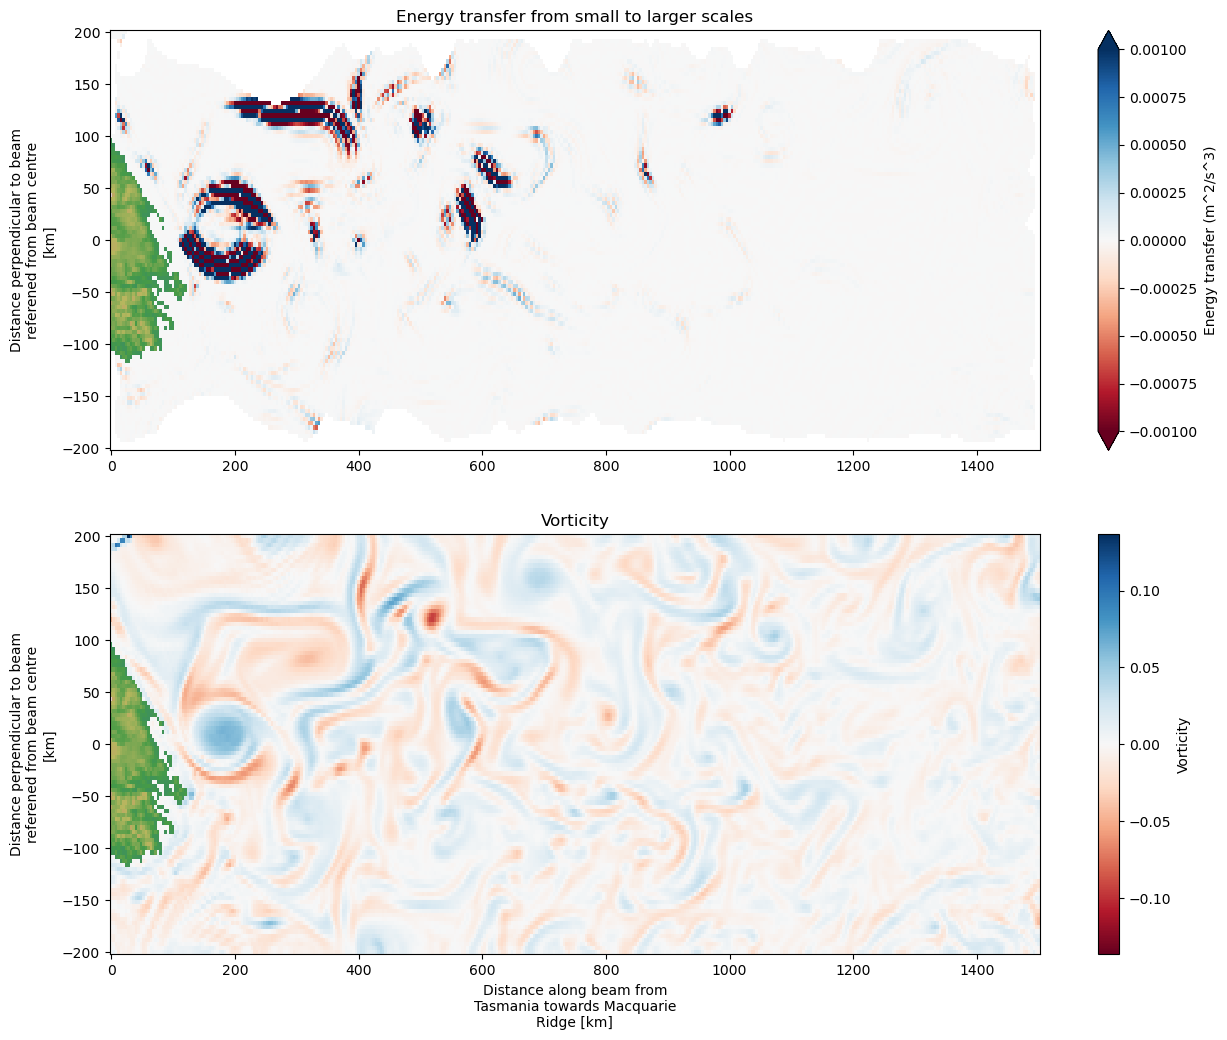

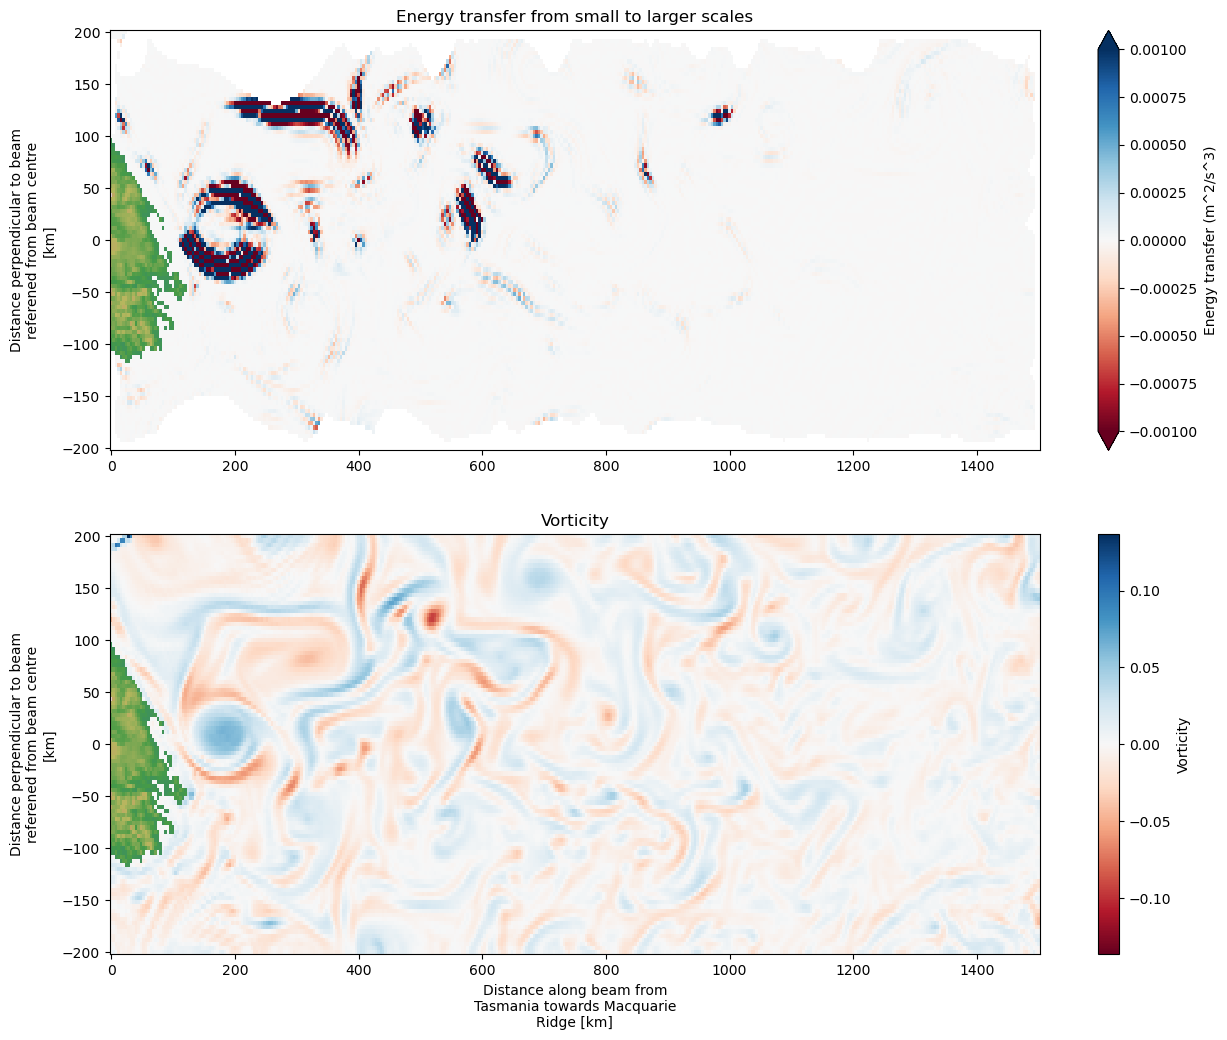

In [7]:
# rawdata = tt.collect_data(
#     expt,
#     rawdata = ["u","v"],
#     timerange=(t0 - time_window,t0 + time_window)).isel(zl = 2)


filtered = xr.open_dataset(outpath + ".nc")

filtered = filtered.assign_coords({
    "time":filtered.time / 3600,
    "xb":filtered.xb / 1000,
    "yb":filtered.yb / 1000})

bathy = xr.open_dataset(f"/g/data/nm03/ab8992/outputs/{expt}/bathy_transect.nc").elevation
bathy = bathy.where(bathy > 0).rename("bathy").drop_vars("lon").drop_vars("lat")
filtered.xb.attrs = bathy.xb.attrs
filtered.yb.attrs = bathy.yb.attrs

for i in filtered.data_vars:
    filtered = filtered.rename({i:i.split("_")[1].lower()})




cst = cross_scale_transfer(filtered)
vorticity = tt.calculate_vorticity(rawdata).rename("vorticity")
merged = xr.merge([cst,bathy,vorticity]).load()

plot_transfer(merged.isel(time = 50),vmax = 0.001)

/jobfs/110357939.gadi-pbs/ipykernel_2181013/1827402562.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap("RdBu")


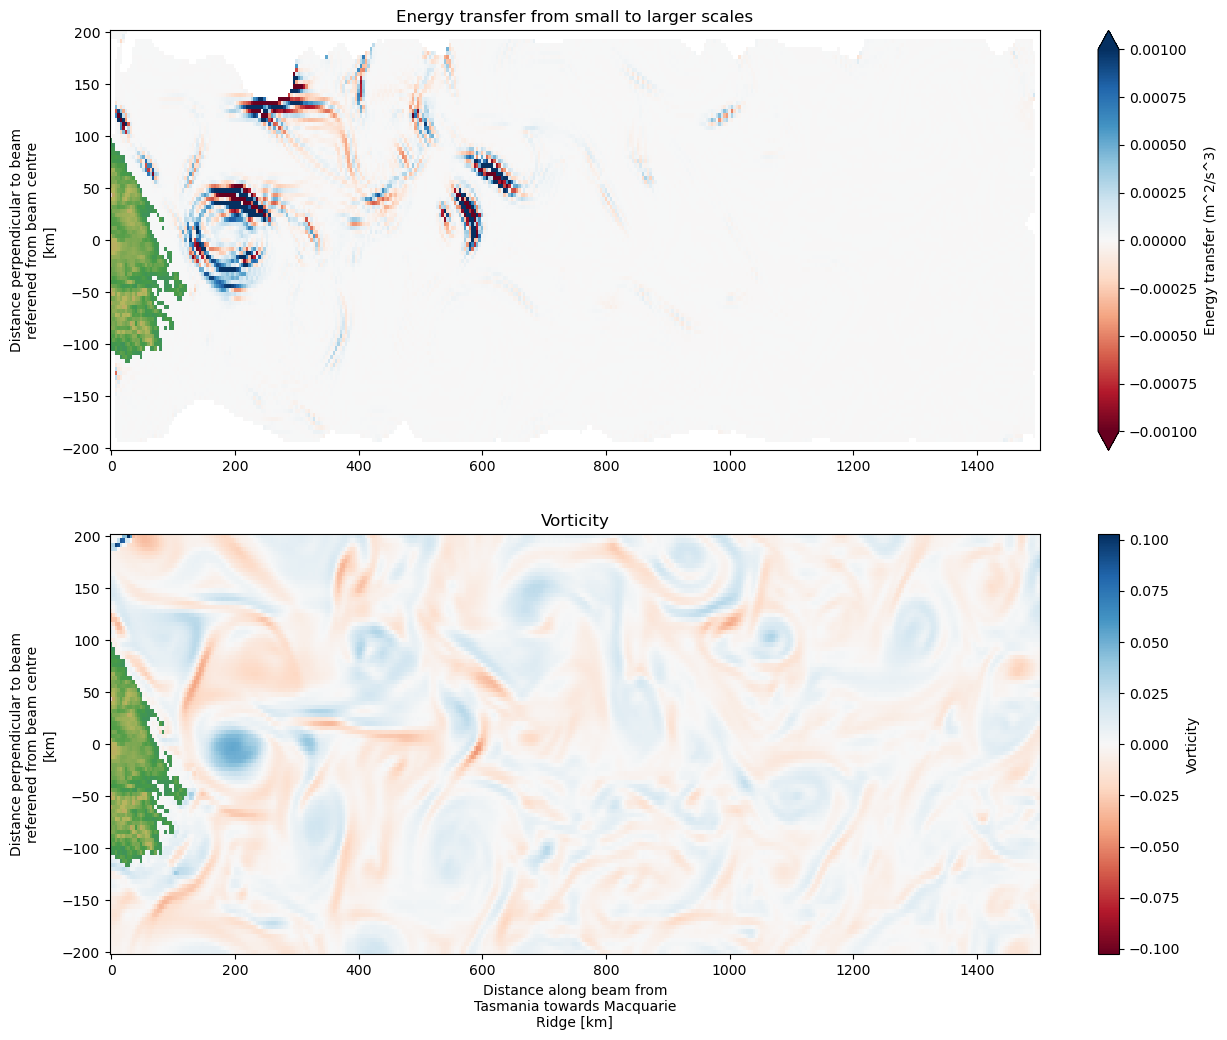

In [9]:
fig = plot_transfer(merged.mean("time"),vmax = 0.001)


/jobfs/110239392.gadi-pbs/ipykernel_1930990/659022346.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap("RdBu")


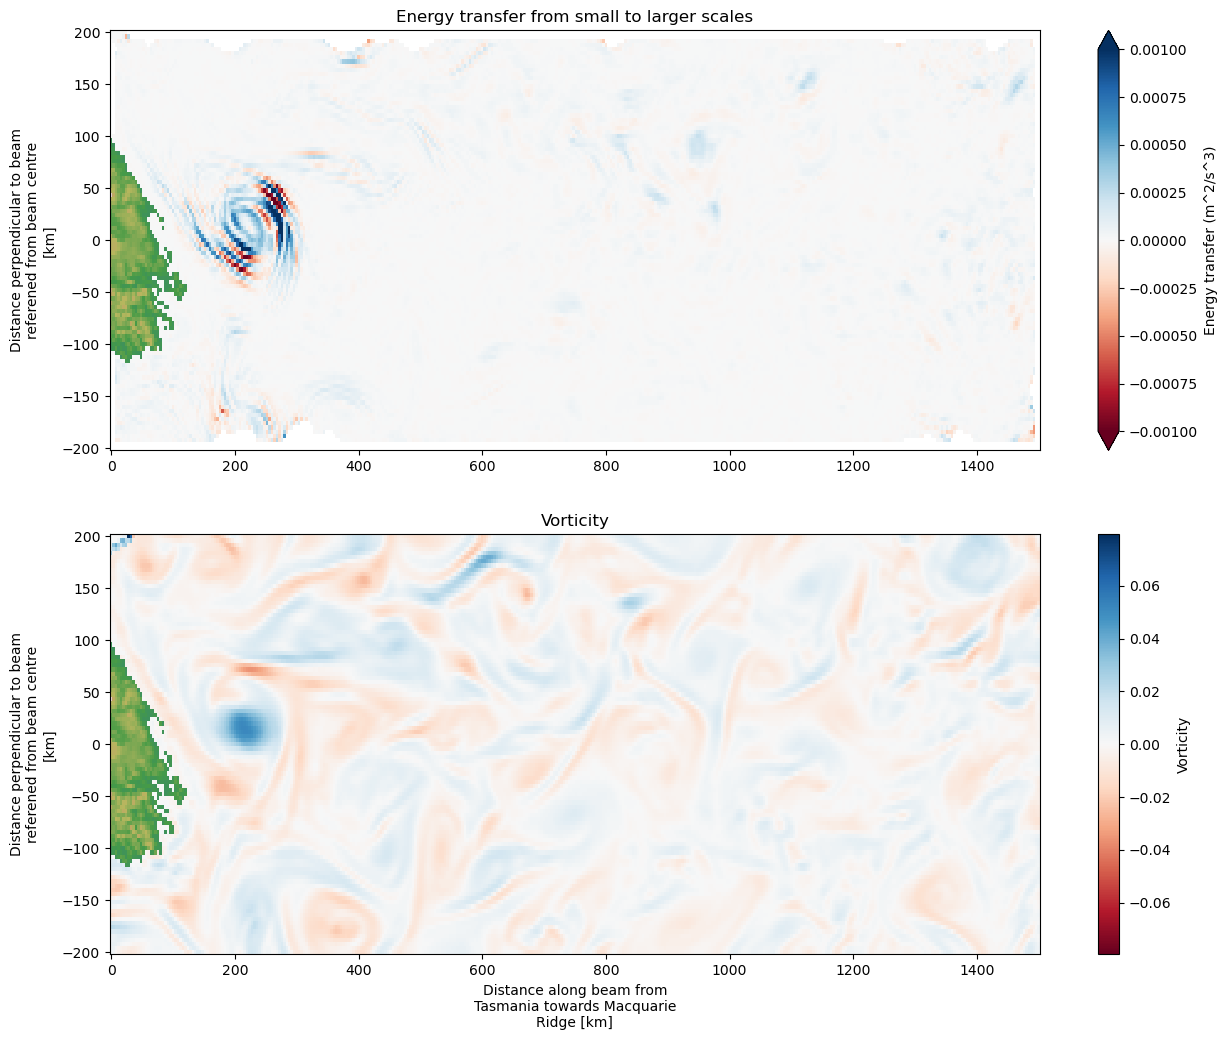

In [32]:

fig = plot_transfer(merged.mean("time"),vmax = 0.001)

In [67]:
merged

<xarray.Dataset>
Dimensions:    (time: 211, xb: 751, yb: 201)
Coordinates:
  * time       (time) float64 4.49e+04 4.49e+04 4.49e+04 ... 1.62e+08 1.62e+08
  * xb         (xb) float64 -0.0 4.0 8.0 12.0 ... 1.492e+06 1.496e+06 1.5e+06
  * yb         (yb) float64 -2e+05 -1.96e+05 -1.92e+05 ... 1.96e+05 2e+05
    zl         float64 30.17
Data variables:
    u          (time, yb, xb) float32 nan nan nan nan nan ... nan nan nan nan
    v          (time, yb, xb) float32 nan nan nan nan nan ... nan nan nan nan
    vv         (time, yb, xb) float32 nan nan nan nan nan ... nan nan nan nan
    uu         (time, yb, xb) float32 nan nan nan nan nan ... nan nan nan nan
    uv         (time, yb, xb) float32 nan nan nan nan nan ... nan nan nan nan
    bathy      (yb, xb) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    vorticity  (time, yb, xb) float32 dask.array<chunksize=(211, 6, 751), meta=np.ndarray>